<h1><center><strong>PRACTICA Nº2</strong></center></h1>
<p><strong>Name</strong> : Carlos Enciso<p>  
<p><strong>Email</strong> : carlos.enciso.o@gmail.com<p>  
<h4><strong>Aims:</strong></h4>
<ol>
    <li>Calcular la climatología de vientos a 850hpa para los meses de DEF, MAM, JJA y SON.</li>
    <li>Estimar las anomalías de viento a 850 para los años 2005 y 2010.</li>
    <li>Realizar la correlación de datos hidrológicos (datos propios) con las anomalías de la TSM</li>
    <li>Discusión de resultados.</li>
</ol> 

In [1]:
%%capture
#======================================
# Importing Libraries 
#======================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cmocean as cmo
from rasterio import features
from affine import Affine
import xarray.ufuncs as xu
import mplleaflet
import os
import eofs
import string
import seaborn as sns
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.io.shapereader import Reader
from shapely.geometry.polygon import LinearRing
from pandas.tseries import converter

In [4]:
#---------------------------
# Reading datasets 
#---------------------------
diri_nc = './DATASETS/'
fili_nc = [os.path.join(diri_nc,x) for x in os.listdir(diri_nc) if 'wnd' in x and x.endswith('.nc')]

In [26]:
ds = xr.open_mfdataset(fili_nc, decode_cf=False)
ds = xr.decode_cf(ds)
ds = ds.sortby(ds.lat)
ds.lon.values = np.where(ds.lon.values==0,360,ds.lon.values)
ds_selected = ds.sel(level=850)
ds_selected_climo = ds_selected.groupby('time.season').mean('time', skipna=True)
ds_windspeed_climo = xu.sqrt(ds_selected_climo.uwnd**2+ds_selected_climo.vwnd**2)
proj=ccrs.PlateCarree()

In [87]:
#===============================
# Funcs for Plottings
#===============================
def nmme_corr_plot(ds, vmin=0, vmax=15, levels=20, ncols=2, nrows=2, cmap=cmo.cm.algae):
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':16}
    proj = ccrs.PlateCarree(central_longitude=180)
    lon_formatter =  LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    cmp = cmap
    border_features = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_countries',
                                                   scale='10m',facecolor=cfeature.COLORS['land'], 
                                                   edgecolor='grey', linewidth=0.4, alpha=.5)
    
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16,7), dpi=200, sharey=True,
                           sharex=True, subplot_kw=dict(projection=proj))
    
    for n, (p,axs) in enumerate(zip(ds,ax.flat)):
        axs.set_xticks(np.arange(60,360,30))
        axs.set_yticks(np.arange(-30,30,10))
        axs.xaxis.set_major_formatter(lon_formatter)
        axs.yaxis.set_major_formatter(lat_formatter)
        axs.add_feature(border_features,zorder=2)
        axs.add_feature(cfeature.LAKES)
        axs.add_feature(cfeature.RIVERS)
        axs.add_feature(cfeature.LAND)
        pls = p.plot.contourf(ax=axs, levels=levels, vmin=vmin, vmax=vmax, add_colorbar=False, 
                              cmap=cmp, transform=ccrs.PlateCarree())
        axs.grid(linestyle='--',color='gray',alpha=0.5)
        axs.set_extent([0, 160, -30, 30],crs=proj)
        axs.set_aspect('auto')
        #axs.text(-0.1,1.05, string.ascii_uppercase[n], transform=axs.transAxes,size=14, weight='bold')
        font['size'] = 11
    fig.colorbar(pls, orientation='vertical', ax=ax, aspect=15, label='Anomaly Correlation (AC)')

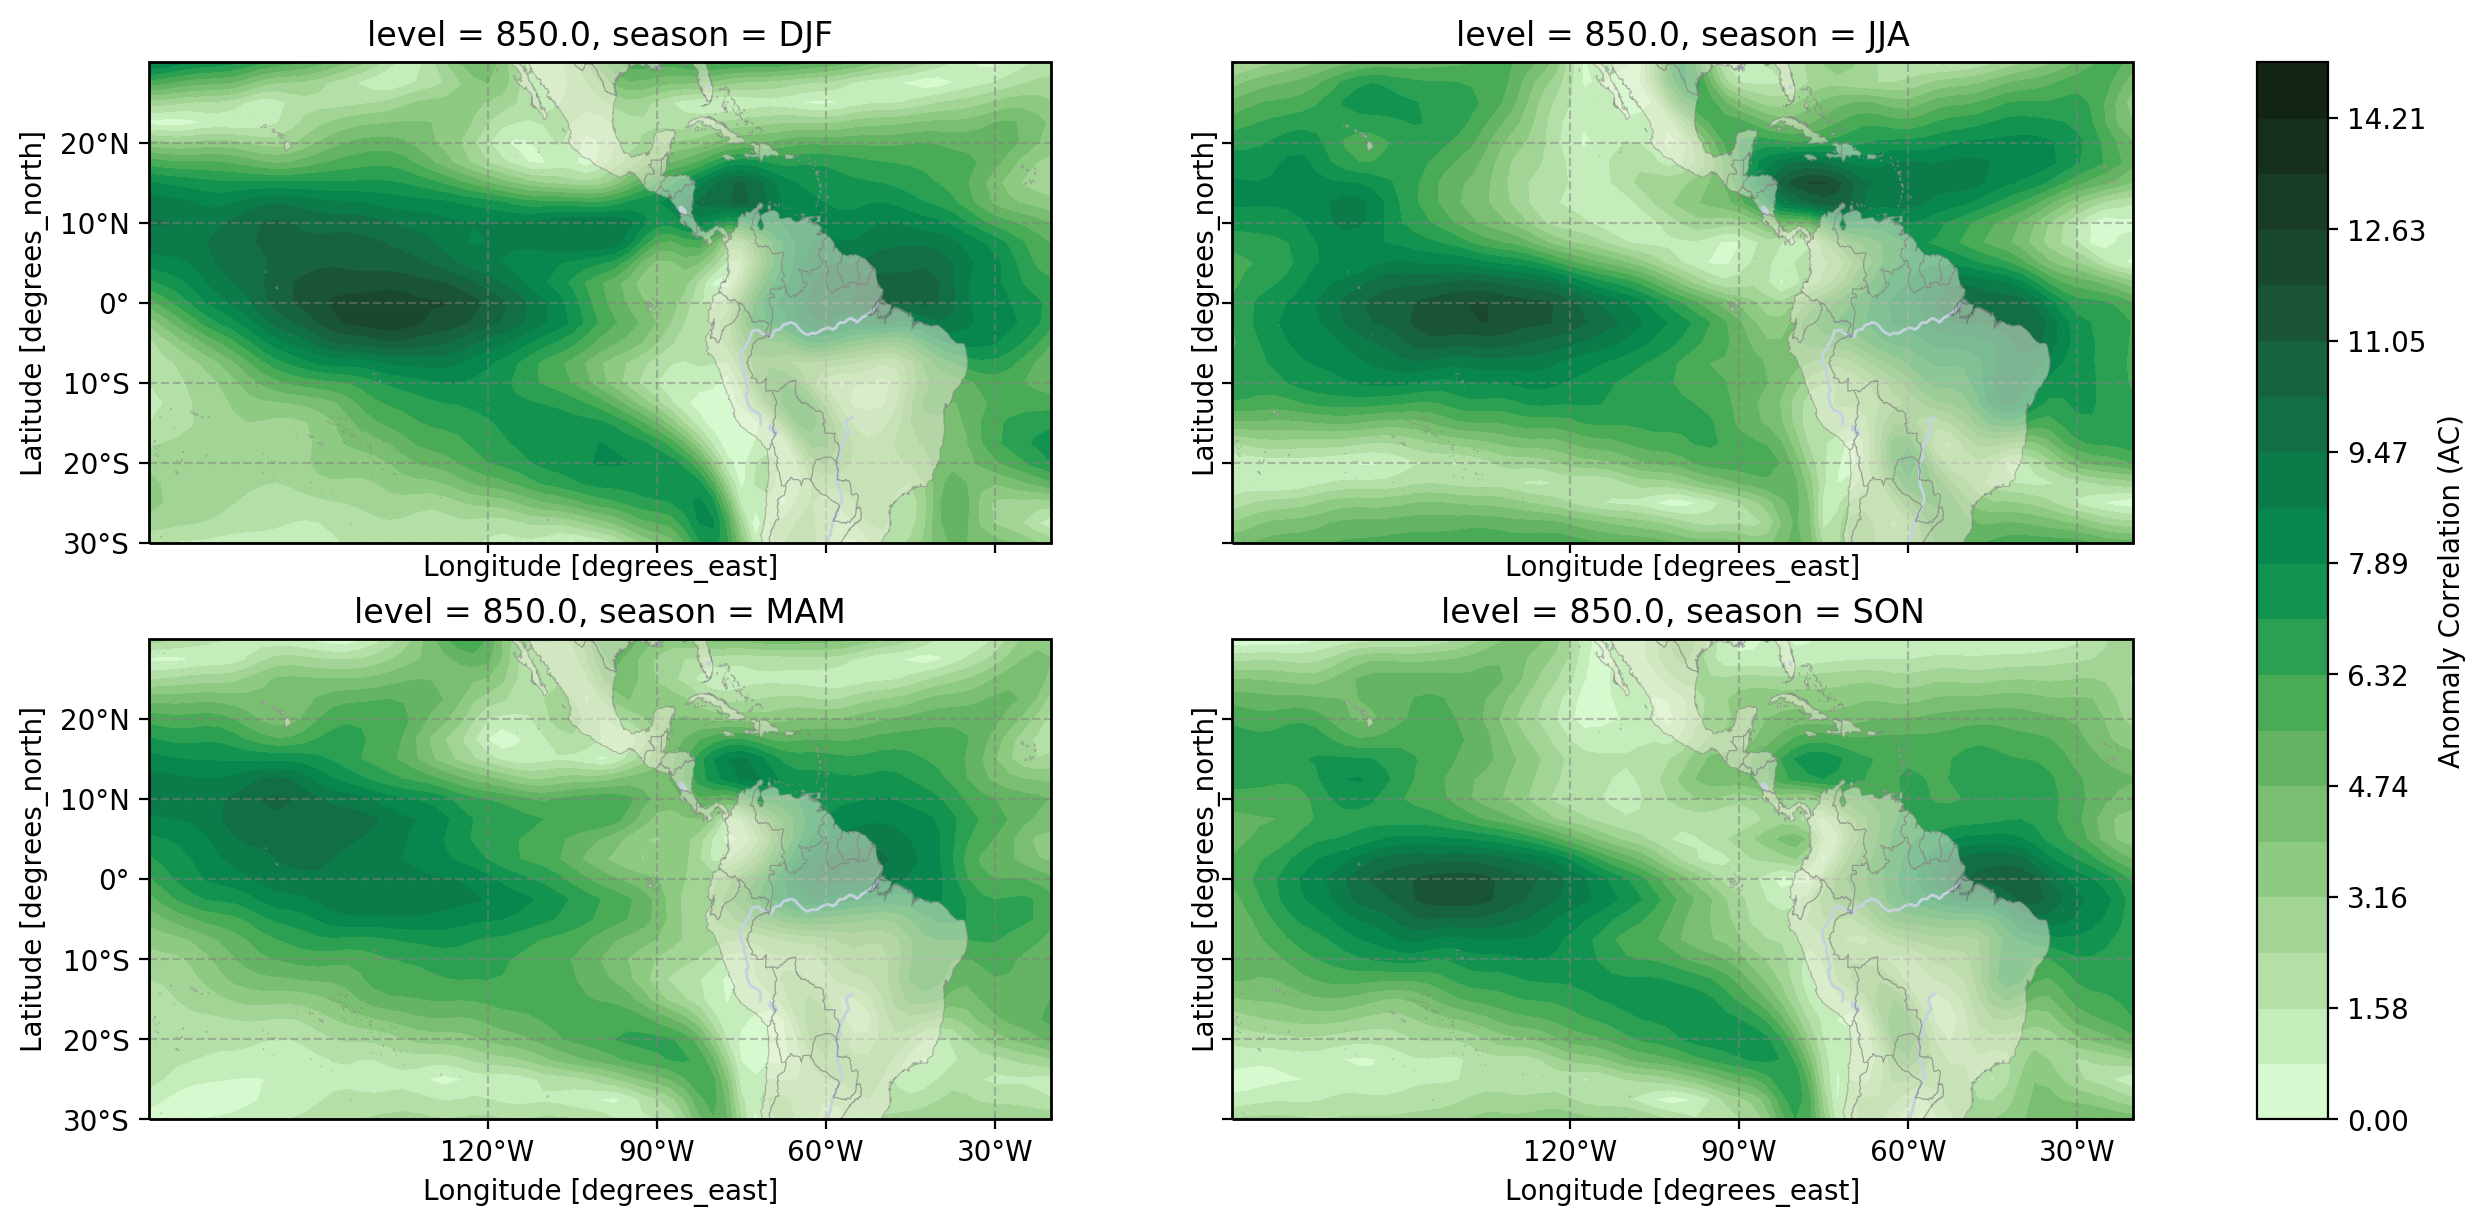

In [88]:
nmme_corr_plot(ds_windspeed_climo)

In [62]:
#windspeed.plot(cmap=plt.cm.Blues, ax=ax)
#plt.title('ECMWF wind speed and direction, June 1, 1984')
#plt.ylabel('latitude')
#plt.xlabel('longitude')
#x = windspeed.coords['lon'].values
#y = windspeed.coords['lat'].values
#ax.streamplot(x, y, ds_selected.uwnd.values, ds_selected.vwnd.values, density=5, cmap=cmo.cm.balance, linewidth=.8)

In [69]:
ds_anom_yearly = ds_selected.groupby('time.month') - ds_selected.groupby('time.month').mean(skipna=True)

/home/carlos/miniconda3/envs/py37/lib/python3.6/site-packages/xarray/core/groupby.py:749: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)
/home/carlos/miniconda3/envs/py37/lib/python3.6/site-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 66 times more chunks
  return self.array[key]


In [84]:
ds_2005_anom = ds_anom_yearly.sel(time=slice('2005-01-01','2005-12-01')).mean(['time'], skipna=True)
ds_2010_anom = ds_anom_yearly.sel(time=slice('2010-01-01','2010-12-01')).mean(['time'], skipna=True)

In [89]:
ds_anom_yearly

<xarray.Dataset>
Dimensions:  (lat: 53, lon: 73, time: 792)
Coordinates:
    level    float32 850.0
  * lat      (lat) float32 -80.0 -77.5 -75.0 -72.5 -70.0 ... 42.5 45.0 47.5 50.0
  * lon      (lon) float32 180.0 182.5 185.0 187.5 ... 352.5 355.0 357.5 360.0
  * time     (time) datetime64[ns] 1951-01-01 1951-02-01 ... 2016-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd     (time, lat, lon) float32 dask.array<shape=(792, 53, 73), chunksize=(1, 53, 73)>
    vwnd     (time, lat, lon) float32 dask.array<shape=(792, 53, 73), chunksize=(1, 53, 73)>